In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import pyedflib as edf

# Gender, 5 samples per individual

In [2]:
trainData = pkl.load(open("/n/scratch2/ms994/standardized_combined_simple_ensemble_train_data_5.pkl", 'rb'))
testData = pkl.load(open("/n/scratch2/ms994/standardized_combined_simple_ensemble_test_data_5.pkl", 'rb'))
validData = pkl.load(open("/n/scratch2/ms994/valid_standardized_combined_simple_ensemble_train_data_5.pkl", 'rb'))

In [3]:
len(trainData), len(testData), len(validData)

(76016, 27932, 20821)

In [4]:
allData = trainData + testData + validData
allRawData = np.stack([datum[0][0:500] for datum in allData])

In [6]:
allRawData.shape

(124769, 500, 21)

In [7]:
allLabels = np.array([datum[1] for datum in allData])

In [8]:
(allLabels == 1).sum() / len(allLabels)

0.46073143168575525

In [9]:
allLabels = np.array([datum[1] for datum in allData])
maleInputData = allRawData[allLabels == 1]
femaleInputData = allRawData[allLabels != 1]

## Freq bins, 5 Hz bins

In [10]:
freq_bins=[0,5,10,15,20,25,30]
maleFFTInputData = read.EdfFFTDatasetTransformer(maleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
maleFFTInputData.verbosity = 500
maleFFTInputFullData = maleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500
retrieving: 12000
retrieving: 12500
retrieving: 13000
retrieving: 13500
retrieving: 14000
retrieving: 14500
retrieving: 15000
retrieving: 15500
retrieving: 16000
retrieving: 16500
retrieving: 17000
retrieving: 17500
retrieving: 18000
retrieving: 18500
retrieving: 19000
retrieving: 19500
retrieving: 20000
retrieving: 20500
retrieving: 21000
retrieving: 21500
retrieving: 22000
retrieving: 22500
retrieving: 23000
retrieving: 23500
retrieving: 24000
retrieving: 24500
retrieving: 25000
retrieving: 25500
retrieving: 26000
retrieving: 26500
retrieving: 27000
retrieving: 

In [11]:
freq_bins=[0,5,10,15,20,25,30]
femaleFFTInputData = read.EdfFFTDatasetTransformer(femaleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
femaleFFTInputData.verbosity = 500
femaleFFTInputFullData = femaleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500
retrieving: 12000
retrieving: 12500
retrieving: 13000
retrieving: 13500
retrieving: 14000
retrieving: 14500
retrieving: 15000
retrieving: 15500
retrieving: 16000
retrieving: 16500
retrieving: 17000
retrieving: 17500
retrieving: 18000
retrieving: 18500
retrieving: 19000
retrieving: 19500
retrieving: 20000
retrieving: 20500
retrieving: 21000
retrieving: 21500
retrieving: 22000
retrieving: 22500
retrieving: 23000
retrieving: 23500
retrieving: 24000
retrieving: 24500
retrieving: 25000
retrieving: 25500
retrieving: 26000
retrieving: 26500
retrieving: 27000
retrieving: 

In [12]:
datum = maleFFTInputFullData[0]
maleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in maleFFTInputFullData]

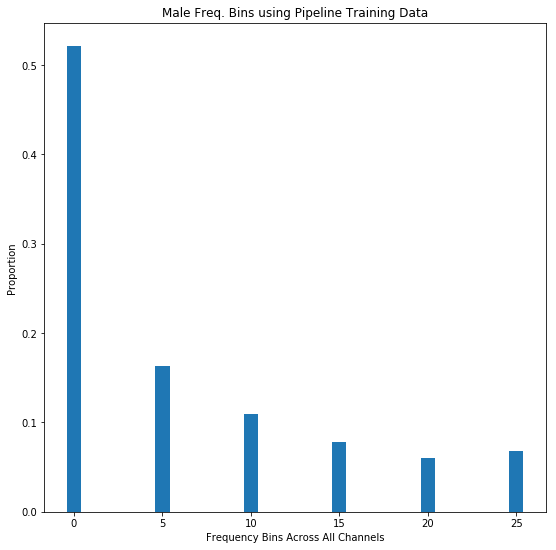

In [13]:
fig = plt.figure(figsize=(9,9))
plt.title("Male Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(maleFFTPropData, axis=0))
plt.savefig("male_freq_big_bins.png", dpi=300)

In [14]:
femaleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in femaleFFTInputFullData]

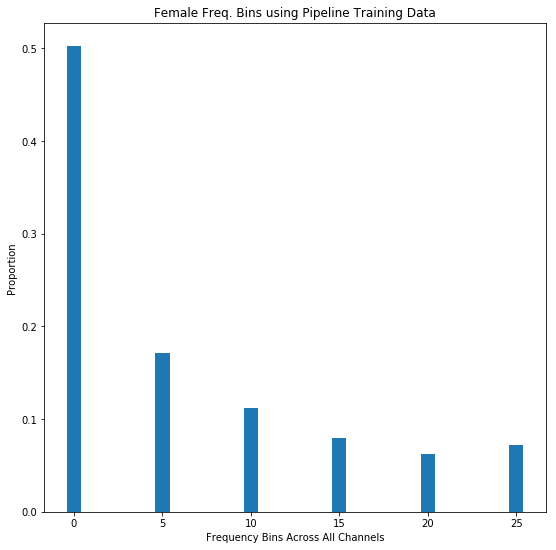

In [15]:
fig = plt.figure(figsize=(9,9))
plt.title("Female Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(femaleFFTPropData, axis=0))
plt.savefig("female_freq_big_bins.png", dpi=300)

In [16]:
femaleFFTnpArray = np.stack([femaleFFTInputFullData[i].values.flatten() for i in range(len(femaleFFTInputFullData))])
maleFFTnpArray = np.stack([maleFFTInputFullData[i].values.flatten() for i in range(len(maleFFTInputFullData))])

In [17]:
allFFT = np.vstack([femaleFFTnpArray, maleFFTnpArray])
del femaleFFTnpArray, maleFFTnpArray

In [18]:
allFFT.shape


(124769, 126)

In [19]:
from sklearn.feature_selection import chi2
chi2vals, pvals = chi2(allFFT, [datum[1] for datum in allData])
pvals = np.nan_to_num(pvals, 1)
len(pvals)
(pvals < (0.001/len(pvals))).sum() / pvals.shape #percent of pvals that are signficant with bonferroni correction

In [20]:
pvals = np.nan_to_num(pvals, 1)

In [21]:
len(pvals)
(pvals < (0.001/len(pvals))).sum() / pvals.shape #percent of pvals that are signficant with bonferroni correction

array([0.86507937])

In [22]:
pvals

array([1.86010476e-119, 1.23489760e-109, 2.00880013e-042, 3.30915014e-103,
       0.00000000e+000, 1.74055757e-057, 3.50507023e-035, 5.27731217e-146,
       2.52986375e-057, 1.24097562e-008, 7.47745118e-159, 7.84390848e-006,
       6.04204553e-238, 0.00000000e+000, 3.11658677e-119, 3.17132589e-005,
       5.41979923e-169, 0.00000000e+000, 8.96885019e-199, 2.23239840e-114,
       0.00000000e+000, 2.51508627e-078, 4.43614707e-102, 7.57643580e-042,
       0.00000000e+000, 0.00000000e+000, 6.70351952e-001, 8.15099766e-067,
       2.46940125e-187, 1.49810981e-103, 5.57902166e-005, 5.66081568e-180,
       3.23783879e-079, 5.76522955e-215, 0.00000000e+000, 2.40392299e-039,
       5.76902948e-139, 3.85105702e-095, 8.60699714e-115, 1.84023851e-021,
       0.00000000e+000, 1.20530586e-042, 0.00000000e+000, 3.71324344e-001,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.19723173e-215, 0.00000000e+000, 0.00000000e+000, 1.22430100e-082,
       0.00000000e+000, 0

In [23]:
chi2vals

array([5.40027098e+02, 4.94881652e+02, 1.86332365e+02, 4.65340519e+02,
       5.41259343e+03, 2.55384182e+02, 1.53176511e+02, 6.62078038e+02,
       2.54639161e+02, 3.24216285e+01, 7.21163064e+02, 1.99755421e+01,
       1.08499027e+03, 1.02881615e+04, 5.38996789e+02, 1.73122694e+01,
       7.67795941e+02, 3.33576082e+03, 9.04779873e+02, 5.16680389e+02,
       2.73510567e+03, 3.51040519e+02, 4.60160306e+02, 1.83691478e+02,
       2.88557033e+03, 1.58314904e+03, 1.81190712e-01, 2.98194143e+02,
       8.52157180e+02, 4.66922115e+02, 1.62404461e+01, 8.18302246e+02,
       3.55128976e+02, 9.79267475e+02, 2.59140918e+03, 1.72235540e+02,
       6.29713637e+02, 4.28278473e+02, 5.18582900e+02, 9.05102206e+01,
       2.12531185e+03, 1.87348591e+02, 2.01689573e+03, 7.99227803e-01,
       1.51157217e+03, 4.04579271e+03, 3.75078544e+03, 1.50091095e+03,
       9.82407946e+02, 3.96921976e+03, 1.56179817e+03, 3.70846487e+02,
       2.36331119e+03, 2.93601034e+03, 2.61461462e+03, 4.45656336e+03,
      

## 1 Hz Bins

In [24]:
freq_bins = [i*1 for i in range(30)]

In [25]:
del maleFFTInputFullData
del femaleFFTInputFullData
maleFFTInputData = read.EdfFFTDatasetTransformer(maleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
maleFFTInputData.verbosity = 500
maleFFTInputFullData = maleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500
retrieving: 12000
retrieving: 12500
retrieving: 13000
retrieving: 13500
retrieving: 14000
retrieving: 14500
retrieving: 15000
retrieving: 15500
retrieving: 16000
retrieving: 16500
retrieving: 17000
retrieving: 17500
retrieving: 18000
retrieving: 18500
retrieving: 19000
retrieving: 19500
retrieving: 20000
retrieving: 20500
retrieving: 21000
retrieving: 21500
retrieving: 22000
retrieving: 22500
retrieving: 23000
retrieving: 23500
retrieving: 24000
retrieving: 24500
retrieving: 25000
retrieving: 25500
retrieving: 26000
retrieving: 26500
retrieving: 27000
retrieving: 

In [26]:
femaleFFTInputData = read.EdfFFTDatasetTransformer(femaleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
femaleFFTInputData.verbosity = 500
femaleFFTInputFullData = femaleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500
retrieving: 12000
retrieving: 12500
retrieving: 13000
retrieving: 13500
retrieving: 14000
retrieving: 14500
retrieving: 15000
retrieving: 15500
retrieving: 16000
retrieving: 16500
retrieving: 17000
retrieving: 17500
retrieving: 18000
retrieving: 18500
retrieving: 19000
retrieving: 19500
retrieving: 20000
retrieving: 20500
retrieving: 21000
retrieving: 21500
retrieving: 22000
retrieving: 22500
retrieving: 23000
retrieving: 23500
retrieving: 24000
retrieving: 24500
retrieving: 25000
retrieving: 25500
retrieving: 26000
retrieving: 26500
retrieving: 27000
retrieving: 

In [27]:
datum = maleFFTInputFullData[0]
maleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in maleFFTInputFullData]

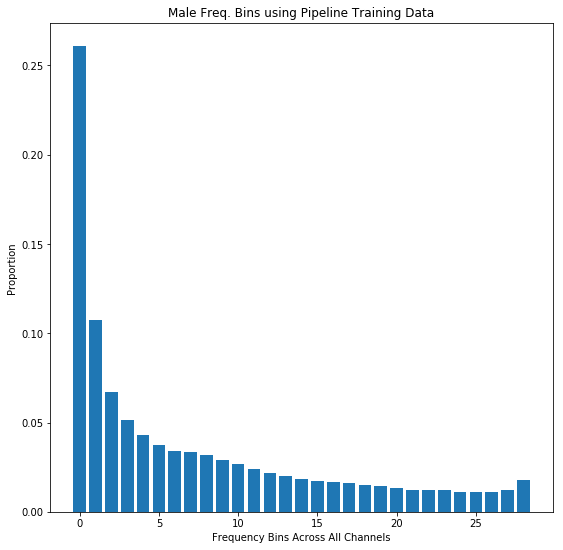

In [28]:
fig = plt.figure(figsize=(9,9))
plt.title("Male Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(maleFFTPropData, axis=0))
plt.savefig("male_freq.png", dpi=300)

In [29]:
np.mean(maleFFTPropData, axis=0)

array([0.26100284, 0.10729346, 0.06685369, 0.05130875, 0.04291683,
       0.03740136, 0.03431417, 0.03326365, 0.03175603, 0.0292389 ,
       0.02700198, 0.02417271, 0.02173264, 0.0198539 , 0.01843899,
       0.01739931, 0.01692388, 0.01594065, 0.01482916, 0.01431472,
       0.01355377, 0.01245068, 0.01205153, 0.01193325, 0.01137047,
       0.01111255, 0.01118527, 0.01236946, 0.01801539])

In [30]:
femaleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in femaleFFTInputFullData]

In [31]:
set([len(datum) for datum in femaleFFTPropData])

{29}

In [32]:
np.mean(femaleFFTPropData, axis=0)

array([0.24269112, 0.10510101, 0.06722816, 0.05206528, 0.04375996,
       0.03871228, 0.03610097, 0.03529424, 0.03337689, 0.03064878,
       0.02779563, 0.02487121, 0.02226618, 0.02042021, 0.01895529,
       0.01775532, 0.01712511, 0.01635171, 0.01541015, 0.01510305,
       0.01398381, 0.01288631, 0.0124795 , 0.01241222, 0.0119102 ,
       0.01161487, 0.01178726, 0.01299154, 0.01890175])

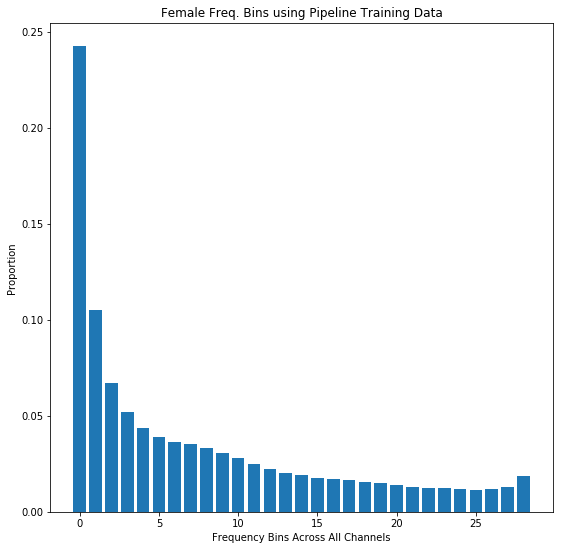

In [33]:
fig = plt.figure(figsize=(9,9))
plt.title("Female Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(femaleFFTPropData, axis=0))
plt.savefig("female_freq.png", dpi=300)

In [34]:
pkl.dump((maleFFTPropData, femaleFFTPropData), open("fft_prop.pkl", "wb"))

In [35]:
maleFFTPropData, femaleFFTPropData = pkl.load(open("fft_prop.pkl", "rb"))

In [38]:
from sklearn.feature_selection import chi2
allFFT = np.vstack([femaleFFTPropData, maleFFTPropData])
chi2vals, pvals = chi2(allFFT, [datum[1] for datum in allData])
pvals = np.nan_to_num(pvals, 1)
len(pvals)
(pvals < (0.001/len(pvals))).sum() / pvals.shape #percent of pvals that are signficant with bonferroni correction

array([0.])

In [39]:
pvals

array([0.20105994, 0.73712067, 0.72967674, 0.63886366, 0.59650331,
       0.70690647, 0.72721515, 0.97147297, 0.77025515, 0.60300338,
       0.73816083, 0.77450977, 0.98230756, 0.86233256, 0.9050509 ,
       0.993915  , 0.87855564, 0.95346016, 0.98894053, 0.9644558 ,
       0.68466244, 0.83634156, 0.85702856, 0.7925174 , 0.74537667,
       0.77885047, 0.72396854, 0.57136295, 0.51351937])

# 1 Samples for Individuals

## 1 Hz Bins

In [40]:
trainData = pkl.load(open("/n/scratch2/ms994/standardized_combined_simple_ensemble_train_data_1.pkl", 'rb'))
testData = pkl.load(open("/n/scratch2/ms994/standardized_combined_simple_ensemble_test_data_1.pkl", 'rb'))
validData = pkl.load(open("/n/scratch2/ms994/valid_standardized_combined_simple_ensemble_train_data_1.pkl", 'rb'))
allData = trainData + testData + validData
allRawData = np.stack([datum[0][0:500] for datum in allData])
freq_bins = [i*1 for i in range(30)]

In [41]:
allLabels = np.array([datum[1] for datum in allData])
maleInputData = allRawData[allLabels == 1]
femaleInputData = allRawData[allLabels != 1]

In [42]:
del maleFFTInputFullData
del femaleFFTInputFullData
maleFFTInputData = read.EdfFFTDatasetTransformer(maleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
maleFFTInputData.verbosity = 500
maleFFTInputFullData = maleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500


In [43]:
femaleFFTInputData = read.EdfFFTDatasetTransformer(femaleInputData, n_process=20, is_tuple_data=False, is_pandas_data=False, freq_bins=freq_bins)
femaleFFTInputData.verbosity = 500
femaleFFTInputFullData = femaleFFTInputData[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000
retrieving: 4500
retrieving: 5000
retrieving: 5500
retrieving: 6000
retrieving: 6500
retrieving: 7000
retrieving: 7500
retrieving: 8000
retrieving: 8500
retrieving: 9000
retrieving: 9500
retrieving: 10000
retrieving: 10500
retrieving: 11000
retrieving: 11500
retrieving: 12000
retrieving: 12500
retrieving: 13000
retrieving: 13500


In [44]:
datum = maleFFTInputFullData[0]
maleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in maleFFTInputFullData]

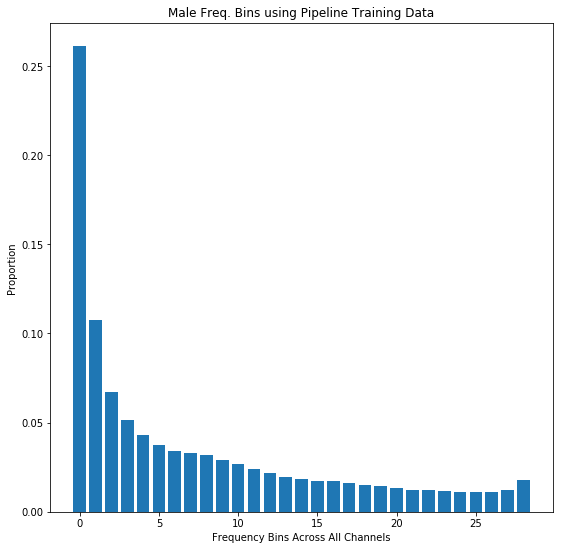

In [45]:
fig = plt.figure(figsize=(9,9))
plt.title("Male Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(maleFFTPropData, axis=0))
plt.savefig("male_freq.png", dpi=300)

In [46]:
np.mean(maleFFTPropData, axis=0)

array([0.26125059, 0.10765018, 0.06716519, 0.05145271, 0.04285484,
       0.03738614, 0.03427576, 0.03316688, 0.03175373, 0.02925577,
       0.02699255, 0.02423439, 0.02172268, 0.01978426, 0.01835177,
       0.01739356, 0.01699766, 0.01590344, 0.01479357, 0.01426167,
       0.01344416, 0.01237983, 0.01194977, 0.01188797, 0.01131058,
       0.01105765, 0.01114145, 0.01233798, 0.01784326])

In [47]:
femaleFFTPropData = [datum.sum(1)/datum.sum().sum() for datum in femaleFFTInputFullData]

In [48]:
set([len(datum) for datum in femaleFFTPropData])

{29}

In [49]:
np.mean(femaleFFTPropData, axis=0)

array([0.24383406, 0.10500567, 0.06736672, 0.05207142, 0.04379217,
       0.03860068, 0.03605412, 0.03521591, 0.03334924, 0.03055637,
       0.0276758 , 0.02482824, 0.02221896, 0.02031368, 0.01895072,
       0.01774018, 0.01717543, 0.01630951, 0.0153427 , 0.01503674,
       0.01390434, 0.01286547, 0.0124206 , 0.01232677, 0.01185787,
       0.01157368, 0.01173744, 0.01299336, 0.01888214])

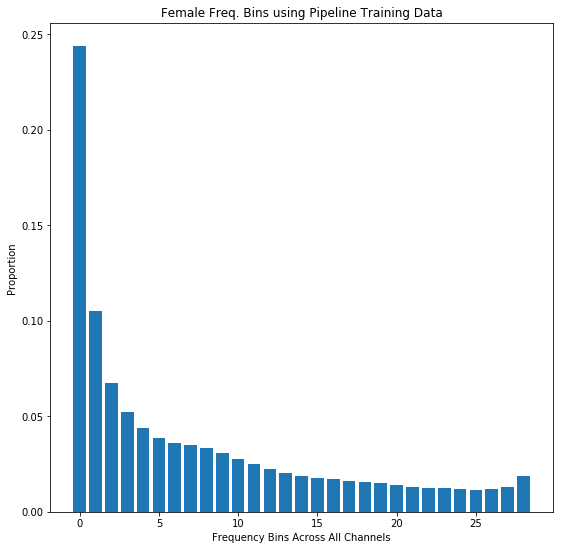

In [50]:
fig = plt.figure(figsize=(9,9))
plt.title("Female Freq. Bins using Pipeline Training Data")
plt.xlabel("Frequency Bins Across All Channels")
plt.ylabel("Proportion")
plt.bar(datum.sum(1).index, np.mean(femaleFFTPropData, axis=0))
plt.savefig("female_freq.png", dpi=300)

In [51]:
pkl.dump((maleFFTPropData, femaleFFTPropData), open("fft_prop.pkl", "wb"))

In [52]:
maleFFTPropData, femaleFFTPropData = pkl.load(open("fft_prop.pkl", "rb"))

In [61]:
allFFT = np.vstack([[datum.values.flatten() for datum in femaleFFTInputFullData], [datum.values.flatten() for datum in maleFFTInputFullData]])

In [62]:
from sklearn.feature_selection import chi2
chi2vals, pvals = chi2(allFFT, [datum[1] for datum in allData])
pvals = np.nan_to_num(pvals, 1)
len(pvals)
(pvals < (0.001/len(pvals))).sum() / pvals.shape #percent of pvals that are signficant with bonferroni correction

array([0.42692939])

# seizure comparison

In [33]:
util_funcs.config=None
util_funcs.read_config()
util_funcs.config.update(util_funcs.config["seizure_config"])
reload(read)

<module 'data_reader' from '/home/ms994/dbmi_eeg_clustering/data_reader.py'>

In [38]:
rawData = read.EdfDataset("combined", "01_tcp_ar", n_process=18)
data = read.EdfFFTDatasetTransformer(rawData, freq_bins=[i for i in range(30)], n_process=20, window_size=pd.Timedelta(seconds=10), non_overlapping=True)
data.verbosity = 500

In [39]:
ten_second_bin_fft_data = data[:]

Starting 20 processes
retrieving: 0
retrieving: 500
retrieving: 1000
retrieving: 1500
retrieving: 2000
retrieving: 2500
retrieving: 3000
retrieving: 3500
retrieving: 4000


In [37]:
util_funcs.get_file_sizes("dev_test", "01_tcp_ar").min()

1    17
dtype: int64

In [40]:
pkl.dump(ten_second_bin_fft_data, open("/n/scratch2/ms994/10_second_bin_fft.pkl","wb"))

In [2]:
ten_second_bin_fft_data =  pkl.load(open("/n/scratch2/ms994/10_second_bin_fft.pkl","rb"))

In [3]:
ten_second_bin_fft_data[600][1]

,start,end,label,p
0,0,334.062,bckg,1
1,334.062,402,tcsz,1
2,402,1390,bckg,1


In [45]:
fftDatum = ten_second_bin_fft_data[600][0]

In [49]:
ten_second_bin_fft_data[600][1].shape

(3, 4)

In [52]:
ann = ten_second_bin_fft_data[600][1]
ann

,start,end,label,p
0,0,334.062,bckg,1
1,334.062,402,tcsz,1
2,402,1390,bckg,1


In [38]:
cummulative = pd.DataFrame(index=[i for i in range(29)], columns=util_funcs.get_annotation_types())

In [39]:
cummulative = cummulative.fillna(0)

In [23]:
cummulative.shape

(29, 27)

In [40]:
cummulativeSubComp = []
for i in range(len(ten_second_bin_fft_data)):
    ann = ten_second_bin_fft_data[i][1]
    fftDatum = ten_second_bin_fft_data[i][0]
    labels = ann.label.unique()
    for label in labels:
        annTemp = (ann[ann.label == label][["start", "end"]]/10).astype(np.int).round(-1)
        for i in annTemp.index:
            summedFFTDatum = fftDatum[:,annTemp.loc[i]["start"]:annTemp.loc[i]["end"]+1].sum(0).sum(0)
            if summedFFTDatum.sum() != 0:
                cummulative[label] += summedFFTDatum / summedFFTDatum.sum()
                cummulativeSubComp.append(summedFFTDatum / summedFFTDatum.sum())

In [30]:
isNan = [np.isnan(cummulativeSubComp[i]).any() for i in range(len(cummulativeSubComp))]

In [32]:
sum(isNan)

2028

In [33]:
sum(isNan)/len(isNan)

0.26489028213166144

In [35]:
summedFFTDatum.sum()

30379987.878137637

In [41]:
cummulative.to_csv("cummulative.csv")

In [ ]:
np.array([comp.isnan().any() for comp in cummulativeSubComp])

Text(0, 0.5, 'Proportion of Distribution')

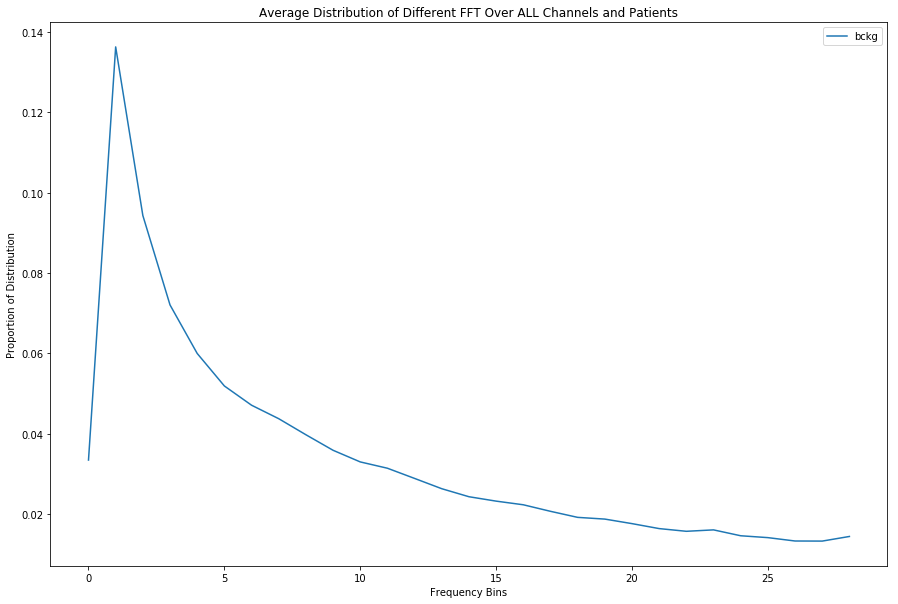

In [59]:
plt.figure(figsize=(15,10))
legends = ["bckg"]

for legend in legends:
    plt.plot(cummulative[legend] / cummulative[legend].sum())


plt.legend(legends)
plt.title("Average Distribution of Different FFT Over ALL Channels and Patients")
plt.xlabel("Frequency Bins")
plt.ylabel("Proportion of Distribution")

Text(0, 0.5, 'Proportion of Distribution')

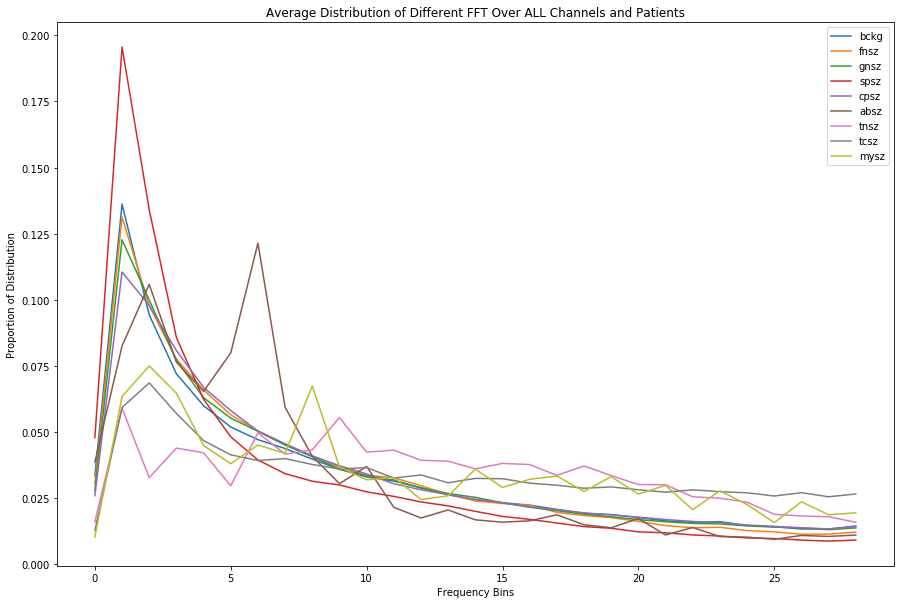

In [58]:
plt.figure(figsize=(15,10))
legends = ["bckg", "fnsz", "gnsz", "spsz", "cpsz", "absz", "tnsz", "tcsz", "mysz"]

for legend in legends:
    plt.plot(cummulative[legend] / cummulative[legend].sum())


plt.legend(legends)
plt.title("Average Distribution of Different FFT Over ALL Channels and Patients")
plt.xlabel("Frequency Bins")
plt.ylabel("Proportion of Distribution")

In [50]:
cummulative.sum(0) == 0

null     True
spsw     True
gped     True
pled     True
eybl     True
artf     True
bckg    False
seiz     True
fnsz    False
gnsz    False
spsz    False
cpsz    False
absz    False
tnsz    False
cnsz     True
tcsz    False
atsz     True
mysz    False
nesz     True
intr     True
slow     True
eyem     True
chew     True
shiv     True
musc     True
elpp     True
elst     True
dtype: bool

In [45]:
cummulative

,null,spsw,gped,pled,eybl,artf,bckg,seiz,fnsz,gnsz,...,mysz,nesz,intr,slow,eyem,chew,shiv,musc,elpp,elst
0,0,0,0,0,0,0,190.976582,0,31.496898,11.759319,...,0.010343,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,776.044503,0,135.357679,51.665095,...,0.063477,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,537.275505,0,100.868962,42.060129,...,0.075020,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,410.637605,0,79.991060,32.501082,...,0.064704,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,341.942080,0,68.011831,26.531319,...,0.044935,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,295.888559,0,58.276214,23.281273,...,0.038045,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,268.644062,0,52.025451,21.170794,...,0.045139,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,249.539467,0,46.826017,18.988436,...,0.041944,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,226.826107,0,42.157616,17.140862,...,0.067423,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,204.811031,0,37.957315,15.176612,...,0.036866,0,0,0,0,0,0,0,0,0


In [ ]:
plt.plot(cummulative[""] / cummulative[""].sum())

In [ ]:
%%bash
scancel 50458750

In [62]:
np.round_(5.5, -1)

10.0

In [ ]:
class FFTCharacterizer(util_funcs.MultiProcessingDataset):
    

In [32]:
len(ten_second_bin_fft_data[0])

21

In [30]:
isSeizure = [datum[1] for datum in data]

KeyboardInterrupt: 

In [ ]:
isSeizure[0]

In [ ]:
np.array([(isSeizure[i].label == "bckg").all() for i in range(len(isSeizure))]).sum() #number of samples with no seizure